In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import PchipInterpolator
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 9
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'  

In [3]:
# LOAD BOMBUS VISIT TIMES, EXTACT SPECIES ABUNDANCE DISTRIBUTION
visit_durations_clover = pd.read_csv('csvs/visit_durations_clover.csv', parse_dates=['visit_start', 'visit_end'])
species_count = visit_durations_clover.value_counts('species').reset_index()
species_count = species_count[species_count['species'] != 'unk']
print(species_count)

        species  count
0  vosnesenskii    173
1      fervidus     70
3  griseocollis     13
4    nevadensis      2
5     appositus      1
6        mixtus      1


In [4]:
cnt_visits_per_hr = pd.read_csv('csvs/cnt_visits_per_hour.csv', parse_dates=['date'])

In [5]:
# FIT BASELINE POISSON MODEL

cnt_visits_per_hr['log_hours'] = np.log(cnt_visits_per_hr['hours']) 

model_pois = smf.glm(
    formula="visit_count ~ 1", 
    data=cnt_visits_per_hr,
    family=sm.families.Poisson(),
    offset=cnt_visits_per_hr['log_hours']
).fit()

pearson_chi2 = sum(model_pois.resid_pearson**2) ## CHECK FOR OVERDISPERSION (>1.5?)
dispersion = pearson_chi2 / model_pois.df_resid
print("Dispersion =", dispersion)
if dispersion > 1.5:
    print("OVERDISPERSED USE NEG BIONOMIAL")

Dispersion = 3.316910978226268
OVERDISPERSED USE NEG BIONOMIAL


In [6]:
# FIT NEGATIVE BINOMIAL MODEL DUE TO OVERDISPERSION
model_nb = smf.glm(
    formula="visit_count ~ 1",
    data=cnt_visits_per_hr,
    family=sm.families.NegativeBinomial(),
    offset=cnt_visits_per_hr['log_hours']
).fit()

print(model_nb.summary())

rate_per_hour = np.exp(model_nb.params['Intercept'])

print("\nEstimated visit rate per hour:", rate_per_hour)
print()

# CHECK FOR ZERO-INFLATION
observed_zero_prop = (cnt_visits_per_hr['visit_count'] == 0).mean()
mu = model_nb.predict()
alpha = model_nb.scale 
predicted_zero_prob = np.mean((1 + alpha * mu) ** (-1/alpha))

print("Observed zero proportion:", observed_zero_prop)
print("Predicted zero (NB) proportion:", predicted_zero_prob)
print()
if predicted_zero_prob > observed_zero_prop:
    print('NO ZERO INFLATION NECESSARY')

                 Generalized Linear Model Regression Results                  
Dep. Variable:            visit_count   No. Observations:                   35
Model:                            GLM   Df Residuals:                       34
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74.101
Date:                Fri, 24 Oct 2025   Deviance:                       31.951
Time:                        13:54:45   Pearson chi2:                     30.1
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4204      0.201     -7.070      0.0

/home/misha/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [7]:
DAY_HOUR_LENGTH = 14   
mu_14h = 0.24161904774478468 * DAY_HOUR_LENGTH 
species_list = species_count['species'].values
p_species = species_count['count'] / species_count['count'].sum()

def rneg_binomial(mu): # NEG BINOMIAL DRAW FUNCTION
    # Var = mu + alpha*mu^2 (alpha=1)
    p = 1 / (1 + mu)
    return np.random.negative_binomial(1, p)

In [8]:
# BOOTSTRAP ONE CAMERA ONE DAY
n_iter = 1000
bootstrap_results = []

for b in range(n_iter):
    total_visits = max(rneg_binomial(mu_14h), 0)

    if total_visits > 0:
        sim_counts = np.random.multinomial(total_visits, p_species)
    else:
        sim_counts = np.zeros_like(p_species, dtype=int)

    bootstrap_results.append(dict(zip(species_list, sim_counts)))

sim_df = pd.DataFrame(bootstrap_results)
sim_df

,vosnesenskii,fervidus,griseocollis,nevadensis,appositus,mixtus
0,3,1,1,0,0,0
1,0,0,0,0,0,0
2,6,0,0,0,0,0
3,2,0,0,0,0,0
4,3,1,0,0,0,0
...,...,...,...,...,...,...
995,5,1,1,0,0,0
996,5,2,0,0,0,0
997,1,0,0,0,0,0
998,0,0,0,0,0,0


In [9]:
# BOOTSTRAP MULT CAMERAS MULT DAYS

def bootstrap_abundances_by_days_and_cameras(
    days_to_test,
    n_iter,
    mu_14h,
    p_species,
    species_names=None,
    cameras_per_day=1,
    random_seed=None
):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    p_species = np.array(p_species, dtype=float)
    n_species = len(p_species)
    
    if species_names is None:
        species_names = [f"sp_{i+1}" for i in range(n_species)]
    
    records = []
    
    for D in days_to_test:
        for C in range(1, cameras_per_day + 1):
            for b in range(n_iter):
                pooled = np.zeros(n_species, dtype=int)
                
                for _ in range(D):
                    for _ in range(C):
                        total_visits = rneg_binomial(mu_14h)
                        if total_visits > 0:
                            pooled += np.random.multinomial(total_visits, p_species)
                
                rec = {
                    "n_days": D,
                    "n_cameras": C,
                    "iter": b
                }
                for name, val in zip(species_names, pooled):
                    rec[name] = val
                
                records.append(rec)
    
    return pd.DataFrame(records)


In [10]:
abundance_df = bootstrap_abundances_by_days_and_cameras(
    days_to_test=[1,5,10,15,20,25],
    n_iter=1000,
    mu_14h=mu_14h,
    p_species=p_species,
    species_names=species_list,
    cameras_per_day=3,
    random_seed=1
)

In [11]:
# COVERAGE ESTIMATION ADAPTED FROM PYNEXT, ONLY CALCULATES OBSERVED COVERAGE
def estimate_coverage(counts):
    counts = counts[counts>0]
    total_reads = sum(counts)
    if total_reads == 0:
        return 0.0
    f1 = sum(counts == 1)
    f2 = sum(counts == 2)
    if f2 == 0:
        f0_hat = (total_reads - 1) / total_reads * f1 * (f1 - 1) / 2
    else:
        f0_hat = (total_reads - 1) / total_reads * f1 ** 2/ 2 / f2
    if f1 > 0:
        alpha = total_reads*f0_hat/(total_reads*f0_hat+f1)
    else:
        alpha = 1
    return 1-f1/total_reads*alpha

In [12]:
abundance_df['coverage'] = abundance_df[species_list].apply(
    lambda row: estimate_coverage(row.values), axis=1
)

In [13]:
summary = abundance_df.groupby(['n_cameras', 'n_days'])['coverage'].agg(
    n='count',                                 
    mean_coverage='mean',
    std_dev='std',
    ci_low_95=lambda x: x.quantile(0.025),
    ci_high_95=lambda x: x.quantile(0.975)
)

summary['std_error'] = summary['std_dev'] / np.sqrt(summary['n'])
summary = summary[['mean_coverage', 'std_dev', 'std_error', 'ci_low_95', 'ci_high_95']]
summary = summary.reset_index()

13.521739130434783
6.7792642140468224
5.414715719063545


(0.7, 1.0)

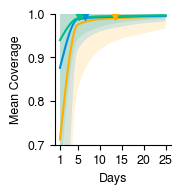

In [14]:
colors = [
    "#ffae00ff",
    "#008ee0ff",
    "#00bd8aff",
]

days_to_test=[1,5,10,15,20,25]
fig, ax = plt.subplots(figsize=(1.5, 1.7))


for idx, cams in enumerate(sorted(summary['n_cameras'].unique())):
    sub = summary[summary['n_cameras'] == cams].sort_values('n_days')
    x = sub['n_days'].astype(float).values
    y = sub['mean_coverage'].astype(float).values
    low = sub['ci_low_95'].astype(float).values
    high = sub['ci_high_95'].astype(float).values

    x_smooth = np.linspace(x.min(), x.max(), 300)
    mean_smooth = PchipInterpolator(x, y)(x_smooth)
    low_smooth = PchipInterpolator(x, low)(x_smooth)
    high_smooth = PchipInterpolator(x, high)(x_smooth)

    color = colors[idx]

    ax.plot(x_smooth, mean_smooth, label=f'{cams} cameras', color=color)
    ax.fill_between(x_smooth, low_smooth, high_smooth, alpha=0.15, color = color, edgecolor=None)

    idx = np.where(mean_smooth >= 0.99)[0]
    if idx.size > 0:
        i = idx[0]
        ax.scatter([x_smooth[i]], 1, s=70, marker='v', color = color, zorder=4)
        print(x_smooth[i])

ax.set_xlabel('Days')
ax.set_xticks(days_to_test)
ax.set_ylabel('Mean Coverage')
ax.set_ylim(0.7,1)

# plt.savefig('figs/resample_trapday_low.svg', format='svg')

### SIMULATE AGAIN WITH HIGHER DIVERSITY

In [15]:
bend_species_counts = np.array([69, 32, 19, 16, 11, 8, 8, 7, 3, 2, 2, 2, 1]) # FROM OBA DATA
bend_species_list = ['vosnesenskii', 'huntii', 'centralis', 'vandykei', 'vancouverensis',
       'griseocollis', 'nevadensis', 'morrisoni', 'melanopygus', 'caliginosus',
       'fervidus', 'rufocinctus', 'occidentalis']
bend_p_species = bend_species_counts / bend_species_counts.sum()


In [16]:
bend_abundance_df = bootstrap_abundances_by_days_and_cameras(
    days_to_test=[1,5,10,15,20,25],
    n_iter=1000,
    mu_14h=mu_14h,
    p_species=bend_p_species,
    species_names=bend_species_list,
    cameras_per_day=3,
    random_seed=1
)

bend_abundance_df

bend_abundance_df['coverage'] = bend_abundance_df[bend_species_list].apply(
    lambda row: estimate_coverage(row.values), axis=1
)

bend_summary = bend_abundance_df.groupby(['n_cameras', 'n_days'])['coverage'].agg(
    n='count',                                 
    mean_coverage='mean',
    std_dev='std',
    ci_low_95=lambda x: x.quantile(0.025),
    ci_high_95=lambda x: x.quantile(0.975)
)

bend_summary['std_error'] = bend_summary['std_dev'] / np.sqrt(bend_summary['n'])
bend_summary = bend_summary[['mean_coverage', 'std_dev', 'std_error', 'ci_low_95', 'ci_high_95']]
bend_summary = bend_summary.reset_index()
bend_summary

,n_cameras,n_days,mean_coverage,std_dev,std_error,ci_low_95,ci_high_95
0,1,1,0.564077,0.385838,0.012201,0.000000,1.0
1,1,5,0.811820,0.154422,0.004883,0.393939,1.0
2,1,10,0.910656,0.064138,0.002028,0.745417,1.0
3,1,15,0.946287,0.038844,0.001228,0.854684,1.0
4,1,20,0.964648,0.024475,0.000774,0.908053,1.0
5,1,25,0.973900,0.018763,0.000593,0.930626,1.0
6,2,1,0.683825,0.272695,0.008623,0.000000,1.0
7,2,5,0.909915,0.067574,0.002137,0.743024,1.0
8,2,10,0.965191,0.024444,0.000773,0.911507,1.0
9,2,15,0.980002,0.013878,0.000439,0.948386,1.0


In [21]:
bend_summary[bend_summary['n_cameras'] ==1]

,n_cameras,n_days,mean_coverage,std_dev,std_error,ci_low_95,ci_high_95
0,1,1,0.564077,0.385838,0.012201,0.000000,1.0
1,1,5,0.811820,0.154422,0.004883,0.393939,1.0
2,1,10,0.910656,0.064138,0.002028,0.745417,1.0
3,1,15,0.946287,0.038844,0.001228,0.854684,1.0
4,1,20,0.964648,0.024475,0.000774,0.908053,1.0
5,1,25,0.973900,0.018763,0.000593,0.930626,1.0


22.431438127090303
15.36789297658863


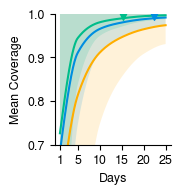

In [19]:
colors = [
    "#ffae00ff",
    "#008ee0ff",
    "#00bd8aff",
]
days_to_test=[1,5,10,15,20,25]
fig, ax = plt.subplots(figsize=(1.5, 1.7))


for idx, cams in enumerate(sorted(bend_summary['n_cameras'].unique())):
    sub = bend_summary[bend_summary['n_cameras'] == cams].sort_values('n_days')
    x = sub['n_days'].astype(float).values
    y = sub['mean_coverage'].astype(float).values
    low = sub['ci_low_95'].astype(float).values
    high = sub['ci_high_95'].astype(float).values

    x_smooth = np.linspace(x.min(), x.max(), 300)
    mean_smooth = PchipInterpolator(x, y)(x_smooth)
    low_smooth = PchipInterpolator(x, low)(x_smooth)
    high_smooth = PchipInterpolator(x, high)(x_smooth)

    color = colors[idx]

    # ax.plot(x_smooth, low_smooth, label=f'{cams} cameras', color=color, alpha=0.6, lw=1)
    ax.plot(x_smooth, mean_smooth, label=f'{cams} cameras', color=color)
    ax.fill_between(x_smooth, low_smooth, high_smooth, alpha=0.15, color = color, edgecolor=None)

    idx = np.where(mean_smooth >= 0.99)[0]
    if idx.size > 0:
        i = idx[0]
        plt.scatter([x_smooth[i]], 1, s=70, marker='v', color = color, zorder=4)
        print(x_smooth[i])

ax.set_xlabel('Days')
ax.set_xticks(days_to_test)
ax.set_ylabel('Mean Coverage')
ax.set_ylim(0.7,1)

plt.savefig('figs/resample_trapday_high.svg', format='svg')

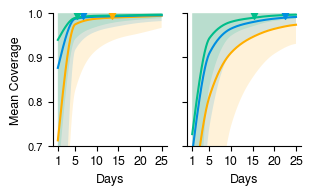

In [18]:

fig, axes = plt.subplots(1, 2, figsize=(3.2, 2), sharey=True)
datasets = [summary, bend_summary]

for ax, data in zip(axes, datasets):
    for idx, cams in enumerate(sorted(data['n_cameras'].unique())):
        sub = data[data['n_cameras'] == cams].sort_values('n_days')
        x = sub['n_days'].astype(float).values
        y = sub['mean_coverage'].astype(float).values
        low = sub['ci_low_95'].astype(float).values
        high = sub['ci_high_95'].astype(float).values

        x_smooth = np.linspace(x.min(), x.max(), 300)
        mean_smooth = PchipInterpolator(x, y)(x_smooth)
        low_smooth = PchipInterpolator(x, low)(x_smooth)
        high_smooth = PchipInterpolator(x, high)(x_smooth)

        color = colors[idx]

        ax.plot(x_smooth, mean_smooth, label=f'{cams} cameras', color=color)
        ax.fill_between(x_smooth, low_smooth, high_smooth, alpha=0.15, color=color, edgecolor=None)

        idx_99 = np.where(mean_smooth >= 0.99)[0]
        if idx_99.size > 0:
            i = idx_99[0]
            ax.scatter([x_smooth[i]], [1], s=70, marker='v', color=color, zorder=4)

    ax.set_xlabel('Days')
    ax.set_xticks(days_to_test)
    ax.set_ylim(0.7, 1.0)
    ax.tick_params(axis='y', labelsize=8)

axes[0].set_ylabel('Mean Coverage')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.savefig('figs/resample_trapday_combined.svg', format='svg', bbox_inches='tight')